## 1. Pre-project preparations

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import squarify
%matplotlib inline

In [2]:
# Import and clean data for RFM calculation: Orders, Segmentation
orders = pd.read_excel(r"C:\Users\Khoi\Desktop\ecommerce retail.xlsx", sheet_name='Orders')
segmentation = pd.read_excel(r"C:\Users\Khoi\Desktop\ecommerce retail.xlsx", sheet_name='Segmentation')

In [3]:
# Orders checking
orders.info()
orders.head()
orders.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


(541909, 8)

In [4]:
# Segmentation checking
segmentation.info()
segmentation.head()
segmentation.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Segment    11 non-null     object
 1   RFM Score  11 non-null     object
dtypes: object(2)
memory usage: 308.0+ bytes


(11, 2)

In [5]:
# Check for null values
orders.isnull().any()

InvoiceNo      False
StockCode      False
Description     True
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID      True
Country        False
dtype: bool

In [6]:
# Check for duplicate values
orders.duplicated().any()

True

In [7]:
# Drop null values
orders = orders[pd.notnull(orders['CustomerID'])]

In [8]:
#check for negatives in Quantity and UnitPrice
print(orders.Quantity.min())
print(orders.UnitPrice.min())

#Considering only positive values 
orders = orders[orders['Quantity']>0]

-80995
0.0


In [9]:
# Remove records where InvoiceNo starts with 'C'
orders = orders[~orders['InvoiceNo'].astype(str).str.startswith('C')]

In [10]:
#Considering current date as 2011-12-10 as the last date in the dataset is from 2010-12 and taking current 
#date(2023-11-25) will be irrelivent for this analysis and model building. 

date_today = dt.datetime(2011,12,10)

orders['TotalAmount'] = orders['Quantity'] * orders['UnitPrice']

## 2. RFM calculation

In [11]:
#RFM Modelling  RFM => Recency Frequency, Monetory
RFM_score = orders.groupby('CustomerID').agg({'InvoiceDate': lambda x: (date_today - x.max()).days, 'InvoiceNo': lambda x: len(x), 'TotalAmount': lambda x: x.sum()})

RFM_score['InvoiceDate'] =  RFM_score['InvoiceDate'].astype('int')

RFM_score.rename(columns = {'InvoiceDate': 'Recency', 'InvoiceNo':'Frequency', 'TotalAmount':'Monetory'}, inplace=True)

RFM_score.reset_index().head()

,CustomerID,Recency,Frequency,Monetory
0,12346.0,325,1,77183.60
1,12347.0,2,182,4310.00
2,12348.0,75,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,310,17,334.40


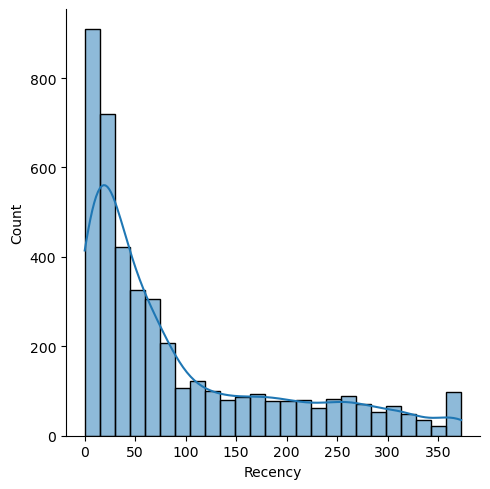

In [12]:
# Recency checking
RFM_score.Recency.describe()

# Plotting using sns.displot
sns.displot(RFM_score['Recency'], kde=True)
plt.show()

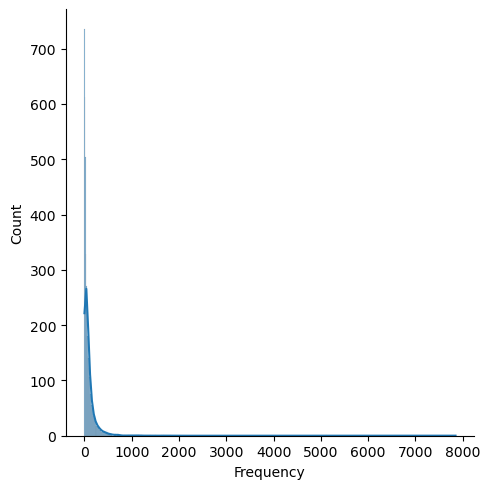

In [13]:
# Frequency checking
RFM_score.Frequency.describe()

# Plotting using sns.displot
sns.displot(RFM_score['Frequency'], kde=True)
plt.show()

In [14]:
#Split into four segments using quantiles [because the data is left-skewed and poorly distributed]
quantiles = RFM_score.quantile(q=[0.2, 0.4, 0.6, 0.8])
quantiles = quantiles.to_dict()
quantiles

{'Recency': {0.2: 13.200000000000045, 0.4: 32.0, 0.6: 71.0, 0.8: 179.0},
 'Frequency': {0.2: 14.0, 0.4: 29.0, 0.6: 58.0, 0.8: 121.0},
 'Monetory': {0.2: 250.10599999999997,
  0.4: 489.72400000000005,
  0.6: 941.9419999999996,
  0.8: 2057.914}}

In [15]:
#Functions to create R, F and M segments
def R_Sc(x,p,d):
    if x <= d[p][0.2]:
        return 5
    elif x <= d[p][0.4]:
        return 4
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 2
    else:
        return 1
    
def FnM_Sc(x,p,d):
    if x <= d[p][0.2]:
        return 1
    elif x <= d[p][0.4]:
        return 2
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 4
    else:
        return 5

In [16]:
RFM_score['R'] = RFM_score['Recency'].apply(R_Sc, args=('Recency', quantiles,))
RFM_score['F'] = RFM_score['Frequency'].apply(FnM_Sc, args=('Frequency', quantiles,))
RFM_score['M'] = RFM_score['Monetory'].apply(FnM_Sc, args=('Monetory', quantiles,))

RFM_score.head()

,Recency,Frequency,Monetory,R,F,M
CustomerID,,,,,,
12346.0,325,1,77183.60,1,1,5
12347.0,2,182,4310.00,5,5,5
12348.0,75,31,1797.24,2,3,4
12349.0,18,73,1757.55,4,4,4
12350.0,310,17,334.40,1,2,2


In [17]:
# Concatnating R, F, M to obtain the RFM score
RFM_score['RFM'] = RFM_score['R'].astype(str) + RFM_score['F'].astype(str) + RFM_score['M'].astype(str)
RFM_score.head()

,Recency,Frequency,Monetory,R,F,M,RFM
CustomerID,,,,,,,
12346.0,325,1,77183.60,1,1,5,115
12347.0,2,182,4310.00,5,5,5,555
12348.0,75,31,1797.24,2,3,4,234
12349.0,18,73,1757.55,4,4,4,444
12350.0,310,17,334.40,1,2,2,122


In [18]:
#Segmentation:
RFM_score['Segment'] = ''

for idx1, row1 in RFM_score.iterrows():
    for idx2, row2 in segmentation.iterrows():
        if row1['RFM'] in row2['RFM Score']: 
            RFM_score.loc[idx1, 'Segment'] = row2['Segment']
            break

RFM_score.head()

,Recency,Frequency,Monetory,R,F,M,RFM,Segment
CustomerID,,,,,,,,
12346.0,325,1,77183.60,1,1,5,115,Cannot Lose Them
12347.0,2,182,4310.00,5,5,5,555,Champions
12348.0,75,31,1797.24,2,3,4,234,At Risk
12349.0,18,73,1757.55,4,4,4,444,Loyal
12350.0,310,17,334.40,1,2,2,122,Hibernating customers


In [19]:
# Aggregate TotalAmount by CustomerID
total_amount_per_customer = orders.groupby('CustomerID')['TotalAmount'].sum().reset_index()
# Merge the total amount data into RFM_score
RFM_score = RFM_score.merge(total_amount_per_customer, on='CustomerID', how='left')
RFM_score.head()

,CustomerID,Recency,Frequency,Monetory,R,F,M,RFM,Segment,TotalAmount
0,12346.0,325,1,77183.60,1,1,5,115,Cannot Lose Them,77183.60
1,12347.0,2,182,4310.00,5,5,5,555,Champions,4310.00
2,12348.0,75,31,1797.24,2,3,4,234,At Risk,1797.24
3,12349.0,18,73,1757.55,4,4,4,444,Loyal,1757.55
4,12350.0,310,17,334.40,1,2,2,122,Hibernating customers,334.40


In [20]:
# Group by segment
segment_data = RFM_score.groupby('Segment', as_index=False).agg({
    'CustomerID': 'count',  # Update this to the actual column name
    'Recency': np.median,
    'Frequency': 'sum',
    'TotalAmount': 'sum'
})

segment_data.rename(columns={'CustomerID': 'Number of Customers', 'Recency': 'Avg Recency', 'Frequency': 'Orders', 'TotalAmount': 'Sales'}, inplace=True)
segment_data['Avg Recency'] = segment_data['Avg Recency'].round(1)
segment_data['Avg orders'] = (segment_data['Orders'] / segment_data['Number of Customers']).round(1)
segment_data['Avg sales'] = (segment_data['Sales'] / segment_data['Number of Customers']).round(1)

segment_data

,Segment,Number of Customers,Avg Recency,Orders,Sales,Avg orders,Avg sales
0,About To Sleep,187,71.0,4065,54420.400,21.7,291.0
1,At Risk,428,129.0,35154,656498.230,82.1,1533.9
2,Cannot Lose Them,89,217.0,4345,296817.691,48.8,3335.0
3,Champions,799,8.0,229212,5452885.340,286.9,6824.6
4,Hibernating customers,803,128.0,18782,324131.962,23.4,403.7
5,Lost customers,433,276.0,5078,77580.980,11.7,179.2
6,Loyal,417,37.0,50793,1024356.890,121.8,2456.5
7,Need Attention,228,29.0,13121,334447.530,57.5,1466.9
8,New Customers,309,24.0,3431,64653.770,11.1,209.2
9,Potential Loyalist,511,25.0,31682,299503.741,62.0,586.1


## 3. Detailed Analysis

### 3.1. Segments Overview 

### Yearly Sales

In [21]:
orders['Year'] = orders['InvoiceDate'].dt.year
yearly_sales = orders.groupby('Year', as_index=False).agg({'TotalAmount': 'sum'})
yearly_sales['Sales'] = yearly_sales['TotalAmount'].round(0)
yearly_sales['%YoY change'] = yearly_sales['TotalAmount'].pct_change().map('{:.2%}'.format)
yearly_sales

,Year,TotalAmount,Sales,%YoY change
0,2010,572713.890,572714.0,nan%
1,2011,8338694.014,8338694.0,1356.00%


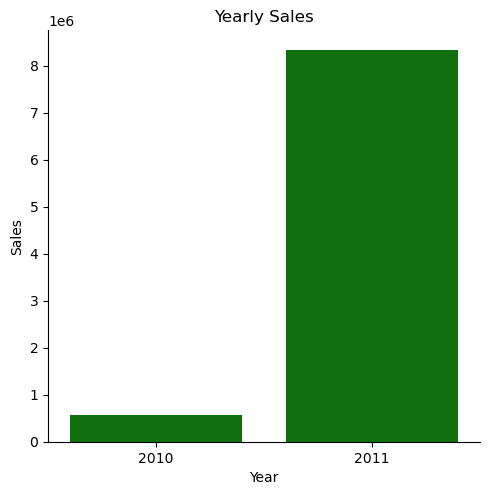

In [22]:
sns.catplot(yearly_sales, x='Year', y='Sales', kind='bar', color='g', errorbar=None)
plt.title('Yearly Sales')
plt.show()

### Yearly Orders

In [23]:
yearly_orders = orders.groupby('Year', as_index=False).agg(Orders=('InvoiceNo', 'nunique'))
yearly_orders['%YoY change'] = yearly_orders['Orders'].pct_change().map('{:.2%}'.format)
yearly_orders

,Year,Orders,%YoY change
0,2010,1400,nan%
1,2011,17136,1124.00%


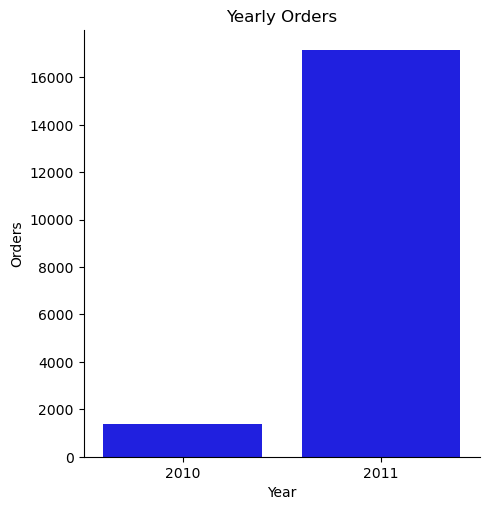

In [24]:
sns.catplot(yearly_orders, x='Year', y='Orders', kind='bar', color='b', errorbar=None)
plt.title('Yearly Orders')
plt.show()

### Customers share by Segment

In [25]:
# Creating color palette
color1 = sns.color_palette('RdYlGn', 11)
color2 = sns.color_palette('GnBu', 11)

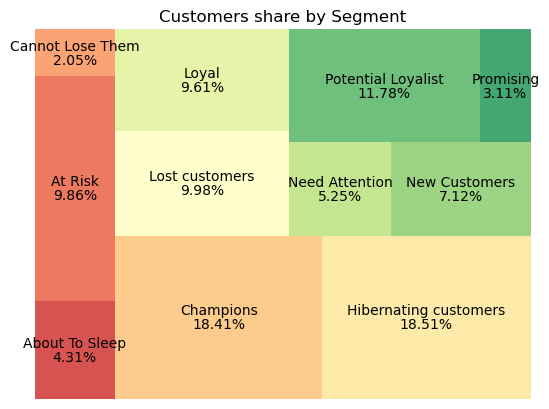

In [26]:
squarify.plot(sizes=segment_data['Number of Customers'], value=(segment_data['Number of Customers'] / segment_data['Number of Customers'].sum()).map("{:.2%}".format), \
              label=segment_data['Segment'], alpha=0.8, color=color1)
plt.title('Customers share by Segment')
plt.axis('off')
plt.show()

### Sales share by Segment

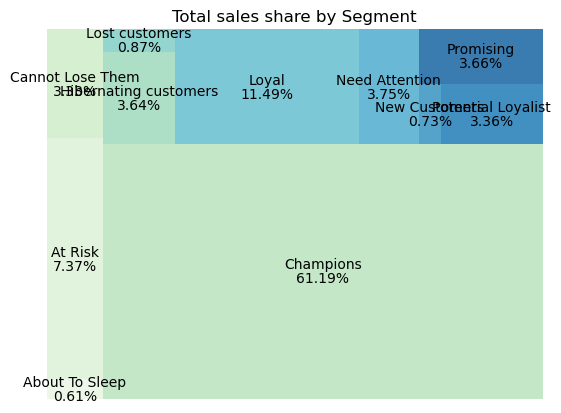

In [27]:
squarify.plot(sizes=segment_data['Sales'], value=(segment_data['Sales'] / segment_data['Sales'].sum()).map("{:.2%}".format), \
              label=segment_data['Segment'], alpha=0.8, color=color2)
plt.title('Total sales share by Segment')
plt.axis('off')
plt.show()

### Average orders per customer by Segment

<Figure size 1000x800 with 0 Axes>

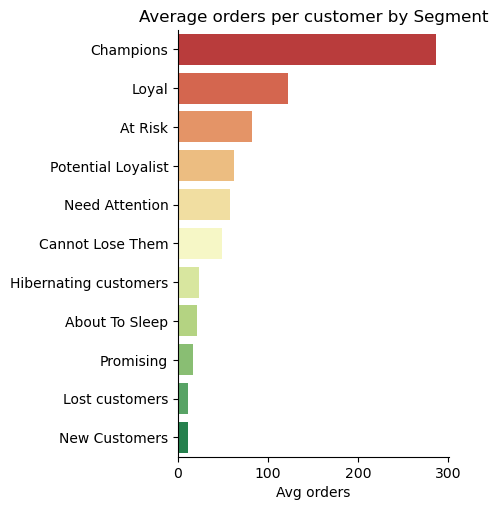

In [28]:
plt.figure(figsize=(10, 8))
sns.catplot(segment_data,
            x='Avg orders',
            y='Segment',
            kind='bar',
            order=segment_data.sort_values('Avg orders', ascending=False)['Segment'],
            palette=color1)

plt.title('Average orders per customer by Segment')
plt.xlabel('Avg orders')
plt.ylabel(None)

plt.show()

### Average sales per customer by Segment

<Figure size 1000x800 with 0 Axes>

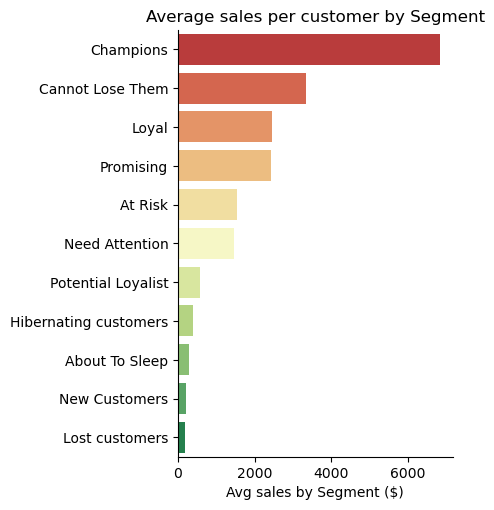

In [29]:
plt.figure(figsize=(10, 8))
sns.catplot(segment_data,
            x='Avg sales',
            y='Segment',
            kind='bar',
            order=segment_data.sort_values('Avg sales', ascending=False)['Segment'],
            palette=color1)
plt.title('Average sales per customer by Segment')
plt.xlabel('Avg sales by Segment ($)')
plt.ylabel(None)
plt.show()

### 3.2. Champions, Cannot Lose Them, Loyal, Promising, At Risk Analysis

#### 3.2.1. Recency by Segment

<Figure size 600x400 with 0 Axes>

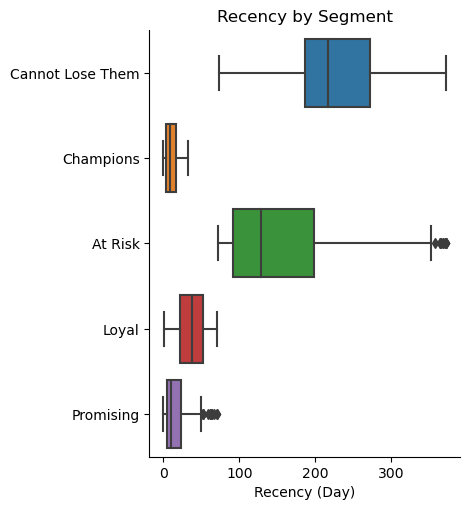

In [33]:
plt.figure(figsize=(6, 4))
sns.catplot(RFM_score[RFM_score['Segment'].isin(['Champions', 'Cannot Lose Them', 'Loyal', 'Promising', 'At Risk'])], x='Recency', y='Segment', kind='box')
plt.title('Recency by Segment')
plt.xlabel('Recency (Day)')
plt.ylabel(None)
plt.show()

1. **Cannot Lose Them**: This segment has a relatively wide interquartile range (IQR), and the median is positioned towards the higher end of the recency scale. This suggests that while there is variation among these customers, many have not made a purchase in quite some time. The strategy here should focus on re-engagement and determining why they've lapsed, as these customers were once valuable.

2. **Champions**: The IQR is tight and skewed towards the lower end of the recency scale, indicating that these customers have made purchases very recently and do so consistently. It is crucial to maintain satisfaction and loyalty among these customers with rewards or exclusive offers to ensure they remain active.

3. **At Risk**: The median recency is higher than that of the Champions, and the IQR is moderately wide with outliers. This suggests that customers in this segment are at risk of becoming inactive. Targeted reactivation strategies, such as personalized offers or reminders of the value they find in the products, may be effective.

4. **Loyal**: The box is stretched, with the median recency being higher than Champions but lower than the At Risk segment. The wide IQR indicates varying levels of engagement within this group. Loyalty programs and regular engagement could help decrease the recency and prevent them from moving into the At Risk segment.

5. **Promising**: This segment has the lowest median recency, indicating that these customers have made purchases very recently, but the spread and outliers suggest that there is some inconsistency in their purchase patterns. Initial engagement strategies should be implemented to build their loyalty and move them into more committed segments like Loyal or even Champions.

#### 3.2.2. Frequency by Segment

<Figure size 600x400 with 0 Axes>

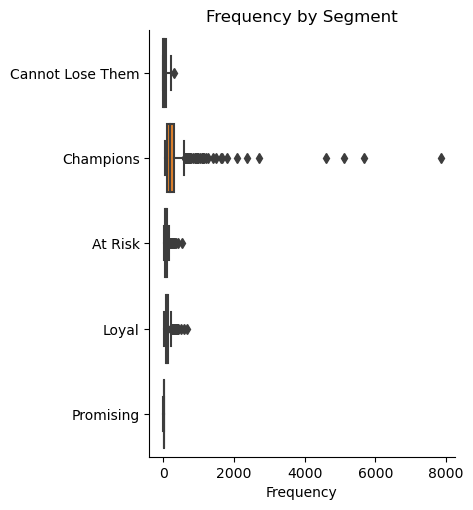

In [34]:
plt.figure(figsize=(6, 4))
sns.catplot(RFM_score[RFM_score['Segment'].isin(['Champions', 'Cannot Lose Them', 'Loyal', 'Promising', 'At Risk'])], x='Frequency', y='Segment', kind='box')
plt.title('Frequency by Segment')
plt.xlabel('Frequency')
plt.ylabel(None)
plt.show()

1. **Cannot Lose Them**: This segment has a relatively broad interquartile range (IQR), indicating variability in purchase frequency. There are outliers indicating some customers with very high frequency. These customers are valuable as they used to purchase often and strategies should be aimed at understanding why their frequency may have decreased and how to re-engage them.

2. **Champions**: This group has a high median frequency and a narrow IQR, signifying consistent purchasing behavior among these customers. They are your most regular and dependable shoppers. It's crucial to maintain their high engagement levels and use them as a model to target similar behaviors in other segments.

3. **At Risk**: This segment's median frequency is lower than that of the Champions, and the IQR is relatively narrow, indicating that the customers in this group generally shop less frequently. The outliers suggest there are a few customers who were once highly frequent shoppers but might have tapered off. Understanding the reasons behind the drop in their shopping frequency could provide insights for retention strategies.

4. **Loyal**: The box representing this segment is slightly lower on the frequency scale, indicating less frequent purchases compared to Champions. However, the range is fairly narrow, which shows a consistent purchasing pattern among the group. Strategies here could involve incentivizing more frequent purchases to move them towards the Champions segment.

5. **Promising**: This segment has the lowest median frequency but shows several outliers with higher frequencies. This suggests that while the segment, on average, does not purchase often, there are a few highly engaged customers. Efforts should be made to understand what drives these outliers and how to encourage similar behaviors in others within the segment.

#### 3.2.3. Monetary by Segment

<Figure size 600x400 with 0 Axes>

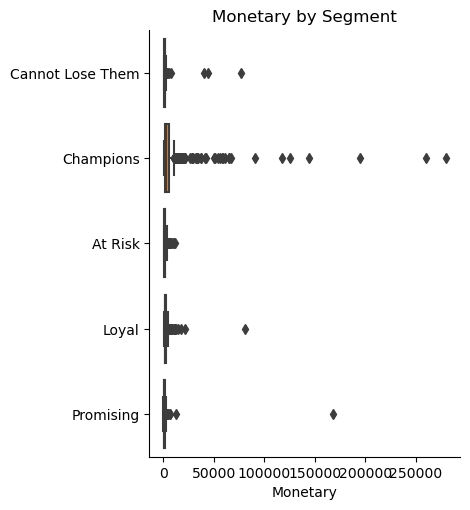

In [35]:
plt.figure(figsize=(6, 4))
sns.catplot(RFM_score[RFM_score['Segment'].isin(['Champions', 'Cannot Lose Them', 'Loyal', 'Promising', 'At Risk'])], x='Monetory', y='Segment', kind='box')
plt.title('Monetary by Segment')
plt.xlabel('Monetary')
plt.ylabel(None)
plt.show()

1. **Cannot Lose Them**: This segment has a high median monetary value, indicating that these customers have historically spent significant amounts. The broad range and presence of outliers suggest that there is a subset of extremely high-value customers in this group. Retention strategies should be prioritized for these customers, possibly with personalized high-value offers, to recapture their business.

2. **Champions**: The median spending for this group is lower than the "Cannot Lose Them" segment but still significant, with a tight interquartile range (IQR) indicating consistency in their spending behavior. The Champions are likely frequent buyers with a steady purchase pattern. Upselling and cross-selling strategies could be effective here, as well as rewards that encourage continued loyalty.

3. **At Risk**: The median monetary value is lower than that of Champions, with a more varied IQR. This suggests that while some customers in this segment have spent well, they are not doing so consistently. Identifying the reasons for this variance can help in tailoring re-engagement strategies to move them back to higher spending habits.

4. **Loyal**: The median spending for Loyal customers is moderate, with the IQR being relatively narrow, which indicates a stable spending pattern. This group could be targeted with loyalty programs that incentivize increased spending, such as tiered rewards based on spending levels.

5. **Promising**: This segment has the lowest median monetary value, with some outliers showing higher spend. These could be newer customers who have the potential to become high-value customers. Early engagement strategies, such as introductory offers or bundling products, could help increase their spending.

### 3.3. Strategic Recommendations for the top 5 segments

Based on the Recency, Frequency, and Monetary (RFM) boxplots provided for different customer segments, let's delve into detailed strategic implications for each type of segment:

#### 1. Cannot Lose Them
**Recency**: This group has a high Recency median, meaning they haven't made a purchase in a while but have historically been significant spenders.

- **Strategic Implications**: Implement win-back campaigns tailored to their known preferences. Offer loyalty incentives or personalized discounts to encourage re-engagement. Conduct exit interviews or surveys to understand their lack of recent purchases and address any issues.

**Frequency**: The range of frequency is broad, suggesting a mix of once-frequent shoppers.

- **Strategic Implications**: Analyze the purchase history to identify products that were frequently bought and target these customers with reminders or promotions for these items. Since they were once frequent shoppers, try to rekindle the relationship with a loyalty program that rewards re-engagement.

**Monetary**: High median monetary value with a wide range indicates significant past spending.

- **Strategic Implications**: Focus on high-value offerings and personalized services. Create VIP experiences or exclusive access to products/services to convey their importance to your business.

#### 2. Champions
**Recency**: Low Recency scores, indicating recent purchases.

- **Strategic Implications**: Maintain engagement with exclusive updates, early access to new products, and personalized experiences. Utilize their feedback to improve products/services as these customers are likely to be highly engaged and willing to provide valuable insights.

**Frequency**: High and consistent frequency of purchases.

- **Strategic Implications**: Encourage Champions to maintain their buying frequency with a subscription model or by introducing a referral program. Consider rewarding them for their loyalty with exclusive offers or membership benefits.

**Monetary**: Consistent spending, though not as high as "Cannot Lose Them".

- **Strategic Implications**: Use upselling and cross-selling tactics to increase their spending. Offer bundles or complimentary products that align with their past purchases.

#### 3. At Risk
**Recency**: Higher Recency compared to Champions, suggesting a growing period of inactivity.

- **Strategic Implications**: Implement targeted reactivation campaigns to prevent further churn. Offer time-limited discounts or remind them of the value proposition that once made them frequent buyers.

**Frequency**: Moderate frequency with some previously frequent buyers.

- **Strategic Implications**: Create personalized re-engagement programs focusing on products they frequently purchased. Offer incentives that encourage a return to previous buying patterns.

**Monetary**: Varied spending behavior, with some high-value outliers.

- **Strategic Implications**: For those with higher spending, consider offering premium customer service or personalized product recommendations to regain their trust and business.

#### 4. Loyal
**Recency**: Generally low, indicating recent interactions.

- **Strategic Implications**: Focus on keeping the brand top of mind with regular communications and updates about products they are interested in. Implement a tiered loyalty program that rewards ongoing engagement.

**Frequency**: Consistent purchasing behavior but less frequent than Champions.

- **Strategic Implications**: Encourage more frequent purchases through regular engagement strategies such as events, community forums, or loyalty points for every purchase.

**Monetary**: Moderate spending with a narrow range, indicating consistent spending habits.

- **Strategic Implications**: Increase their monetary contribution by introducing them to a wider range of products. Offer a loyalty card or points system that incentivizes higher spending.

#### 5. Promising
**Recency**: Very low Recency suggests very recent engagement.

- **Strategic Implications**: Solidify their recent purchase experience with excellent follow-up service. Encourage product reviews and offer information on how to get the most out of their purchase.

**Frequency**: Lowest among all segments, but with potential for growth.

- **Strategic Implications**: Encourage repeat purchases with follow-up offers. Introduce a welcome series campaign that educates them on the brand's value and product range.

**Monetary**: Lowest median spending, indicating room for growth.

- **Strategic Implications**: Identify products in their price range to recommend during follow-up communications. Offer introductory discounts on their next purchase to increase their spending.

#### Overall Strategic Approach:
- **Data-Driven Personalization**: Use the data from RFM analysis to create highly personalized and targeted marketing campaigns for each segment.
- **Customer Journey Optimization**: Understand the specific journey of each segment and optimize the touchpoints to improve engagement, frequency, and spending.
- **Customer Lifecycle Marketing**: Develop strategies that address customers at different lifecycle stages, aiming to move them from Promising to Loyal, then to Champions, while re-engaging those At Risk and Cannot Lose Them.
- **Product and Service Development**: Use insights from RFM segmentation to inform the development of products and services that meet the needs of different customer groups.
- **Feedback and Adaptation**: Continuously collect customer feedback, especially from the Champions and At Risk segments, to adapt offerings and strategies accordingly.

### 3.4. Selecting the parameter: R/F/M

In a retail context, emphasizing Frequency (F) in the RFM model can be particularly beneficial for the following detailed reasons:

#### Customer Relationship Building

1. **Repeat Business**:
   - Frequent shoppers are more likely to continue buying. Identifying and nurturing these customers can help maintain a steady revenue flow.
   - Frequent visits create more touchpoints for building a relationship. Each visit is an opportunity to engage with the brand and reinforce customer loyalty.

2. **Customer Lifetime Value (CLV)**:
   - Frequent buyers typically have a higher CLV. Focusing on increasing purchase frequency can be more cost-effective than constantly acquiring new customers.
   - Strategies that increase frequency, like loyalty programs, can significantly boost the overall CLV of the customer base.

3. **Customer Feedback and Data**:
   - Regular customers provide ongoing feedback and data with each interaction, allowing the retailer to refine product offerings and customer service.
   - This data can help understand purchasing patterns and preferences, leading to better stock management and personalized marketing.

#### Marketing and Sales Strategies

1. **Targeted Promotions**:
   - Use purchase history data from frequent shoppers to tailor promotions and communications.
   - Develop targeted marketing campaigns that recognize and reward frequent purchases, such as loyalty discounts or early access to sales.

2. **Personalization**:
   - Implement personalized recommendations based on shopping behavior. Frequent buyers provide a rich data set for predictive analytics and personalized upselling.
   - Personalization can lead to increased basket size and fosters a sense of being valued, encouraging even more frequent visits.

#### Operational Efficiency

1. **Inventory Management**:
   - Purchase frequency data can help optimize inventory turnover rates. Knowing which products are purchased most frequently aids in maintaining ideal stock levels.
   - Frequent purchases across various product categories can provide insights into cross-selling opportunities.

2. **Resource Allocation**:
   - By focusing on the customers who shop most often, the business can allocate resources like staffing and marketing spend more effectively to when and where they are most needed.
   - Customer service resources can be better managed to ensure that frequent shoppers receive the attention they need to maintain their buying habits.

#### Brand Advocacy

1. **Referrals**:
   - Customers who shop frequently are more likely to become brand advocates. They can be encouraged to refer friends and family, expanding the customer base through word-of-mouth.
   - Implementing a referral program can incentivize frequent shoppers to share their positive experiences with others.

2. **Community Building**:
   - Frequent shoppers can form the core of a brand's community. Inviting them to exclusive events or online forums can foster a community feeling.
   - Engaging with this community can provide valuable insights and create brand ambassadors who share their enthusiasm for the retailer with a wider audience.

#### Strategic Development

1. **Predictive Analytics**:
   - Analyzing the patterns of frequent shoppers allows for predictive modeling of shopping behavior, helping anticipate future trends and demand.
   - Predictive analytics can inform strategic decisions, from marketing campaigns to store layout changes.

2. **Business Growth**:
   - By increasing purchase frequency, a retailer can grow its business sustainably without solely relying on customer acquisition.
   - Growth strategies can be designed around upselling and cross-selling to existing frequent shoppers.

In summary, focusing on Frequency in the retail sector can provide stability and growth by fostering loyal customer relationships, improving operational efficiencies, and enhancing the overall customer experience. This approach can help develop a strong, loyal customer base that not only contributes to steady revenue but also promotes the brand through advocacy and community engagement.